In [1]:
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot
import pandas as pd
pyplot.rcParams['figure.figsize'] = 12, 5

paul_output = pd.read_csv('irrelevance-output.txt', sep=' ', header=None)

paul_output.columns = ['sid', 'string']
paul_output['string'] = paul_output.string.apply(lambda x: x[::-1])

william_output = pd.read_csv('./william-code/COLAG_2011_sentID_rel_new.txt', sep='\t', header=None)
william_output.columns = ['sid', 'kind', 'sentence', 'string']

In [4]:
len(paul_output), len(william_output)

(48077, 48077)

In [13]:
param_names = {
    0: 'sp',
    1: 'hip',
    2: 'hcp',
    3: 'opt',
    4: 'ns',
    5: 'nt',
    6: 'whm',
    7: 'pi',
    8: 'tm',
    9: 'VtoI',
    10: 'ItoC',
    11: 'ah',
    12: 'QInv'
}

# Parameter Distribution

Comparison between the number of occurances of 0, 1, ~ and * for William and Paul's output.

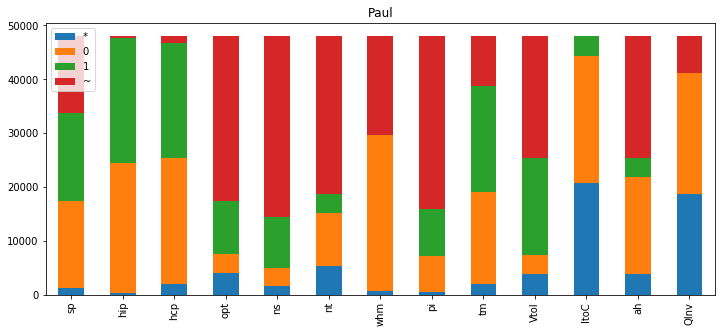

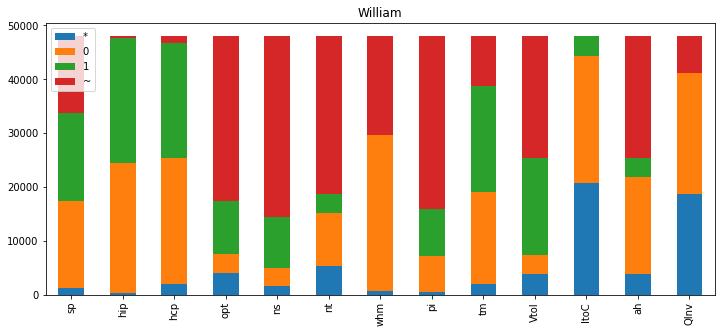

In [15]:
both = william_output.join(paul_output, on='sid', lsuffix='_w', rsuffix='_p')
paul_params = (both.string_p
 .apply(list)
 .apply(pd.Series)
)
william_params = (both.string_w
 .apply(list)
 .apply(pd.Series)
)
paul_params.columns = [param_names[i] for i in range(13)]
william_params.columns = [param_names[i] for i in range(13)]
paul_params.apply(lambda x: x.value_counts()).T.plot.bar(stacked=True, title="Paul")
william_params.apply(lambda x: x.value_counts()).T.plot.bar(stacked=True, title="William");

# Per-parameter rate of agreement

The ratio of the number of times the Paul and William agreed, over the total number of sentences.

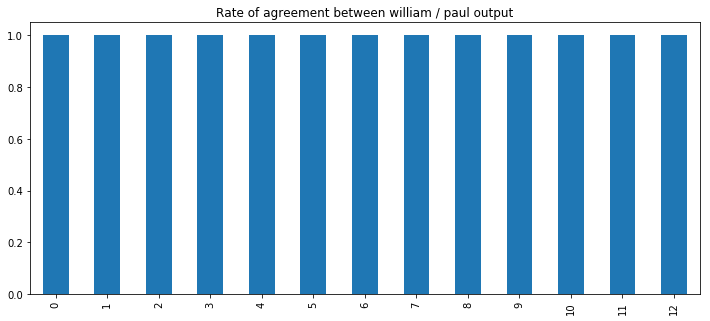

In [24]:
(
    paul_params
    .eq(william_params)
    .sum()
    .div(len(william_params))
    .plot.bar(title='Rate of agreement between william / paul output')
);

# Sample of differing irrelevence strings

In [7]:
disagree = ~both.string_w.eq(both.string_p)
both[disagree].sample(10)[['sentence', 'kind', 'string_w', 'string_p']]

ValueError: a must be greater than 0

In [ ]:
# load the colag db
colag = pd.read_csv('./COLAG_2011_flat_formatted.txt', 
                    delimiter='\t', 
                    header=None, 
                    names=['gram', 'infl', 'sent'],
                    dtype='object')
colag['sent'] = colag.sent.str.strip()
colag.sample(4)

# Manual Test

We'll do a manual test for irrelevance / ambiguity on an input for which william and paul disagree:

    O3 P S O2 O1[+WH] Never Verb ka

In [ ]:
sentence = 'O3 P S O2 O1[+WH] Never Verb ka'
both[both.sentence.eq(sentence)][['string_w', 'string_p']]

In [ ]:
param_cols = colag.gram.apply(list).apply(pd.Series)
param_cols.columns = ['P{}'.format(i) for i in np.arange(1, 14)]

In [ ]:
generators = colag[colag.sent.eq(sentence)].gram.values
generators

In [ ]:
def toggled(param, grammar):
    """ Returns grammar with parameter number `parameter` toggled

    >>> gram = int('0100', 2)
    >>> t = toggled(3, gram)
    >>> "{0:b}".format(t)
    '1100'
    """
    return grammar ^ (1 << param)

def min_pairs(grammar):
    return ['{0:013b}'.format(toggled(param, int(grammar, 2)))
            for param in range(len(grammar))]

## First grammar

In [ ]:
generators[0]

In [ ]:
min_pairs(generators[0])

In [ ]:
[len(colag[colag.gram.eq(g) & colag.sent.eq(sentence)])
 for g in min_pairs(generators[0])]

In [ ]:
ambiguous = colag[colag.sent.eq(sentence)].gram.apply(list).apply(pd.Series).nunique().gt(1).astype(int)
ambiguous.index = reversed(ambiguous.index)
ambiguous

In [ ]:
x = {generator: [len(colag[colag.gram.eq(g) & colag.sent.eq(sentence)])
                 for g in min_pairs(generator)]
     for generator in generators}
x

In [ ]:
irrel = pd.DataFrame(x).T

In [ ]:
ambiguous + irrel

# Another example

In [ ]:
sentence = "S[+WH][+WA] ka Aux Not Verb O1 O2 P O3"
sentence = "O3 Aux S Never Verb O1[+WH] O2 P"
generators = colag[colag.sent.eq(sentence)].gram.values
generators

In [ ]:
ambiguous = colag[colag.sent.eq(sentence)].gram.apply(list).apply(pd.Series).nunique().gt(1).astype(int)
ambiguous.index = reversed(ambiguous.index)
ambiguous.pipe(pd.DataFrame).T

In [ ]:
x = {generator: [len(colag[colag.gram.eq(g) & colag.sent.eq(sentence)])
                 for g in min_pairs(generator)]
     for generator in generators}
irrel = pd.DataFrame(x).T

In [ ]:
y = irrel.any().astype(int)

In [ ]:
y.index = reversed(y.index)

In [ ]:
y.astype(str).replace('1', '~')

In [ ]:
both[both.sentence.eq(sentence)]

In [ ]:
irrel

# Finding a tractable manual test case

In [ ]:
def num_licensed(sentence):
    return len(colag[colag.sent.eq(sentence)])

In [ ]:
sample = both[disagree].sample(10)
pd.DataFrame([
sample.string_p.str.contains('~'), sample.string_p.str.contains('\*'), sample.sentence.apply(num_licensed)]).T

In [ ]:
target = (
    both.string_p.str.contains('\*') 
    & both.string_p.str.contains('~')
    & both.string_p.ne(both.string_w))

In [ ]:
both.loc[32425]

# Tractable manual test case

Paul & William disagree on `O3[+WA] S P O2[+WH] O1 Verb ka`, and only 8 grammars generate it.

In [ ]:
sentence = 'O3[+WA] S P O2[+WH] O1 Verb ka'
generators = colag[colag.sent.eq(sentence)]
generators

In [ ]:
for gram_num in range(0, 8):
    print([len(colag[colag.gram.eq(g) & colag.sent.eq(sentence)])
                     for g in min_pairs(generators.iloc[gram_num].gram)])

In [ ]:
both[both.sentence.eq(sentence)]

In [ ]:
both[target].sample(20).apply(num_licensed)

# Disallowed Grammar Set

In [ ]:
william_ng = pd.read_csv('./NG_GrammIDs.txt', header=None)[0]

In [ ]:
len(range(2**13))

In [ ]:
from irrelevate_sentences import read_colag_tsv
colag = read_colag_tsv('COLAG_2011_ids.txt')
grammars = set([g
                for grams in colag.values()
                for g in grams])

paul_ng = {g for g in range(2**13)
           if g not in grammars}


In [ ]:
paul_ng.difference(william_ng.values)

In [ ]:
set(william_ng.values).difference(paul_ng)